# Programing exercise 5: ODE integrators

Due on Monday, 26.11.2018, 14.15h

### Total: 100 points

## The problem

We will again consider the collective Ising spin-model with a transverse field, as in programming exercise 4, which is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. We studied this model in detail on the previous exercise sheet using exact diagonalization. Now we want to test how different numerical integrators perform on this problem and use exact diagonalziation as a benchmark.

In [1]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse as sparse

%matplotlib inline

### Exact diagonalization code

Here is an example implemetation of the exact diagonalization which you can use and compare to.

Definitions for building the Hamiltonian

In [2]:
def buildSx(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz(N):
    return sparse.diags(np.arange(N+1)-N/2)

def buildH(N,ome):
    Sx = buildSx(N)
    Sz = buildSz(N)
    return -Sz @ Sz/N - ome*Sx 

Here we calculate the time evolution using exact diagonalization. This will be used to benchmark the performance of the numerical integrators.

### Exercise 1 (15 points)

Now we want to use different integrators to see how they perform. A code for testing the Euler method has already been implemeted for you. Run it and describe your observations. Play with the step size in the 1st part.

Intergration with Euler:

Integrate with a given step size to see accuracy.

In [3]:
def Euler_step(y,Hmat,dt):
    return y - 1j*dt*Hmat @ y
def Runge_Kutta2(y,Hmat,dt):
    return y - 1j*dt*Hmat @ y - dt**2*1/2*(Hmat@Hmat)@y
def two_step_method(Psin,Psin1,Hmat,dt):
    return - 2j*dt*Hmat @ Psin +Psin1

Note: To have a clear notebook we put all plots in one function to prevent rather large repetetive blocks of code. 

In [45]:
def operation(Ni,dti,integrator,intString='Euler',scipyODE=False):
    #assign variables
    dt = 0.1
    tend = 10
    tsteps = int(np.round(tend/dt))
    tvec = np.linspace(0,dt*tsteps,tsteps+1)
    tvecED = tvec

    ome = 0.6

    N = Ni
    dim = N+1
    ini = np.eye(1,dim,0)[0]

    Sz = buildSz(N)
    Sx = buildSx(N)
    Sz2 = Sz @ Sz
    Hmat =buildH(N,ome)

    observables = 1j*np.zeros((2,len(tvec)))

    # ED solution
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i] = Szval
        observables[1,i] = Sxval
    t2=time.time()
    print('time for ED was '+str(t2-t1))


    if np.max(observables.imag) > 0.001:
        print("Some observables have non-zero imaginary parts(ED)!!")

    observablesED = observables.real

    dt = dti
    tsteps = int(np.round(tend/dt)) # always integrate up to tend
    tvec = np.linspace(0,dt*tsteps,tsteps+1)

    tvecint = tvec;

    observables = 1j*np.zeros((3,len(tvec))) # container for observables

    t1=time.time() # measure time

    Psit=ini # initialize wave function

    # store initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,0] = Szval
    observables[1,0] = Sxval
    observables[2,0] = norm
    r=None
    integrator_number=0
    if scipyODE:
        integrator_number=3
        r=ode(integrator).set_integrator('zvode', method='adams', with_jacobian=False)
        r.set_initial_value(ini, 0).set_f_params(Hmat)
    else:
        integrator_number=[Euler_step,Runge_Kutta2,two_step_method].index(integrator)
        
    if (integrator_number==0 or integrator_number==1):
        # Integration steps:
        for i in range(1,len(tvec)):
            Psit = integrator(Psit, Hmat, dt)
            Szval = Psit.conj().T @ Sz @ Psit
            Sxval = Psit.conj().T @ Sx @ Psit
            norm = np.sqrt(Psit.conj().T @ Psit)
            observables[0,i] = Szval
            observables[1,i] = Sxval
            observables[2,i] = norm
        t2=time.time()
        print('time for %s was '%intString+str(t2-t1))
    elif (integrator_number==2):
        Psit=[ini] # initialize wave function
        #first runge kutta step for initialisation
        Psit.append(Runge_Kutta2(Psit[0],Hmat,dt))
        Szval = Psit[1].conj().T @ Sz @ Psit[1]
        Sxval = Psit[1].conj().T @ Sx @ Psit[1]
        norm = np.sqrt(Psit[1].conj().T @ Psit[1])
        observables[0,1] = Szval
        observables[1,1] = Sxval
        observables[2,1] = norm
        # Integration steps:
        for i in range(2,len(tvec)):
            Psi = two_step_method(Psit[i-1],Psit[i-2],Hmat, dt)
            Szval = Psi.conj().T @ Sz @ Psi
            Sxval = Psi.conj().T @ Sx @ Psi
            norm = np.sqrt(Psi.conj().T @ Psi)
            Psit.append(Psi)
            observables[0,i] = Szval
            observables[1,i] = Sxval
            observables[2,i] = norm
        t2=time.time()
        print('time for the %s method was '%intString+str(t2-t1))
    elif(integrator_number==3):#scipy integrate ode
        for i in range(1,len(tvec)):
            Psit = r.integrate(i*dt)
            Szval = Psit.conj().T @ Sz @ Psit
            Sxval = Psit.conj().T @ Sx @ Psit
            norm = np.sqrt(Psit.conj().T @ Psit)
            observables[0,i] = Szval
            observables[1,i] = Sxval
            observables[2,i] = norm
        t2=time.time()
        print('time for %s was '%intString+str(t2-t1))
        
    if np.max(observables.imag) > 0.001:
        print("Some observables have non-zero imaginary parts!!")
    observablesint = observables.real


    # plotting comparisons to ED and norm

    plt.plot(tvecED,observablesED[0]/N,'k--')
    plt.plot(tvecint,observablesint[0]/N)
    plt.ylim([-1,1])
    plt.xlim([0,tvecint[-1]])
    plt.xlabel('$t$')
    plt.ylabel('$S_z/N$')
    plt.legend(['exact diagonalization',intString])
    plt.show()

    plt.plot(tvecED,observablesED[1]/N,'k--')
    plt.plot(tvecint,observablesint[1]/N)
    plt.ylim([-1,1])
    plt.xlim([0,tvecint[-1]])
    plt.xlabel('$t$')
    plt.ylabel('$S_x/N$')
    plt.show()
    
    plt.title('Norm evolution in time')
    plt.plot(tvecint,observablesint[2],label=intString)
    plt.plot([tvecint[0],tvecint[-1]],[1,1],'k--',label='optimal')
    plt.ylim([0,2])
    plt.xlabel('t')
    plt.ylabel('norm')
    plt.legend()
    plt.show()
    
    
    ###################################################################################################
    dtout = tvecED[1]-tvecED[0]

    # in each iteration, divide the step size by some factor
    red_factor = 2 # must be integer in this implementation
    n_red_step = 11

    deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

    dt = dtout
    nsteps_per_dtout = 1

    step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

    # decrease the time step in each iteration
    for istepize in range(n_red_step):
    
        step_sizes[istepize] = dt

        # initialize
        Psit=ini

        #initial values of observables
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepize,0,0] = Szval - observablesED[0,0]
        deviations[istepize,1,0] = Sxval - observablesED[1,0]
        deviations[istepize,2,0] = norm - 1
        #following is run for rungekutta2 or euler

        if (integrator_number==0 or integrator_number==1):
            # propagation
            for i in range(1,len(tvecED)):
                # proparagte to next output time
                for k in range(nsteps_per_dtout):
                    Psit = integrator(Psit, Hmat, dt)
                # record deviations    
                Szval = Psit.conj().T @ Sz @ Psit
                Sxval = Psit.conj().T @ Sx @ Psit
                norm = np.sqrt(Psit.conj().T @ Psit)
                deviations[istepize,0,i] = Szval - observablesED[0,i]
                deviations[istepize,1,i] = Sxval - observablesED[1,i]
                deviations[istepize,2,i] = norm - 1

        #two_step method
        elif (integrator_number==2):
            for i in range(1,len(tvecED)):
                Psit=[ini]
                Psit.append(Runge_Kutta2(Psit[0],Hmat,dt))
            # proparagte to next output time
                #use a shifted k as we need it to call our last two elements
                for k in range(2,nsteps_per_dtout+2):
                    Psit.append( two_step_method(Psit[k-1],Psit[k-2],Hmat,dt))
                # record deviations    
                Szval = Psit[-1].conj().T @ Sz @ Psit[-1]
                Sxval = Psit[-1].conj().T @ Sx @ Psit[-1]
                norm = np.sqrt(Psit[-1].conj().T @ Psit[-1])
                deviations[istepize,0,i] = Szval - observablesED[0,i]
                deviations[istepize,1,i] = Sxval - observablesED[1,i]
                deviations[istepize,2,i] = norm - 1
        #scipy ode
        elif (integrator_number==3):
            #initalize integrator
            r=ode(integrator).set_integrator('zvode', method='adams', with_jacobian=False)
            r.set_initial_value(ini, 0).set_f_params(Hmat)
            # propagation
            for i in range(1,len(tvecED)):
                # proparagte to next output time
                Psit = r.integrate(i*nsteps_per_dtout*dt)
                # record deviations    
                Szval = Psit.conj().T @ Sz @ Psit
                Sxval = Psit.conj().T @ Sx @ Psit
                norm = np.sqrt(Psit.conj().T @ Psit)
                deviations[istepize,0,i] = Szval - observablesED[0,i]
                deviations[istepize,1,i] = Sxval - observablesED[1,i]
                deviations[istepize,2,i] = norm - 1
        # reduce time step
        dt = dt/red_factor
        nsteps_per_dtout = nsteps_per_dtout*red_factor


    if np.max(deviations.imag) > 0.001:
        print("Some observables have non-zero imaginary parts!!")

    deviations = np.abs(deviations)
    itstepsize = 10
    plt.plot(tvecED,deviations[itstepsize,0],'k')
    plt.title('time step : '+ str(step_sizes[istepize]))
    plt.xlabel('t')
    plt.ylabel('$S_z$ absolute error')
    plt.show()

    plt.plot(tvecED,deviations[itstepsize,1],'k')
    plt.title('time step : '+ str(step_sizes[istepize]))
    plt.xlabel('t')
    plt.ylabel('$S_x$ absolute error')
    plt.show()

    plt.plot(tvecED,deviations[itstepsize,2],'k')
    plt.title('time step  '+ str(step_sizes[istepize]))
    plt.xlabel('t')
    plt.ylabel('norm error')
    plt.show()
    
    if integrator_number==3:
        return
    plt.loglog(step_sizes,deviations[:,1,-1],'k')
    plt.loglog(step_sizes,10**3*step_sizes,'r--')
    plt.title('error scaling')
    #plt.ylim([10**-1,10**2])
    plt.legend(['Integrator error','$a*dt^1$'])
    plt.xlabel('time step')
    plt.ylabel('Sx absolut error at t=10')
    

    plt.loglog(step_sizes,deviations[:,1,-1],'k')
    plt.loglog(step_sizes,10**3*step_sizes,'r--')
    plt.title('error scaling')
    #plt.ylim([10**-1,10**2])
    plt.legend(['%s error'%intString,'$a*dt^1$'])
    plt.xlabel('time step')
    plt.ylabel('Sx absolut error at t=10')
    plt.show()

time for ED was 0.02698349952697754
time for Euler was 1.5720288753509521


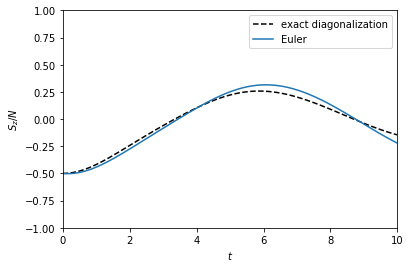

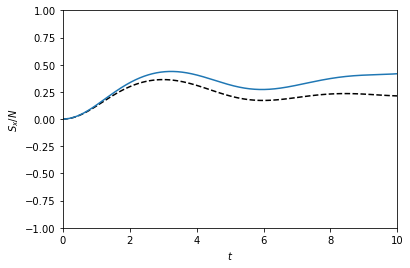

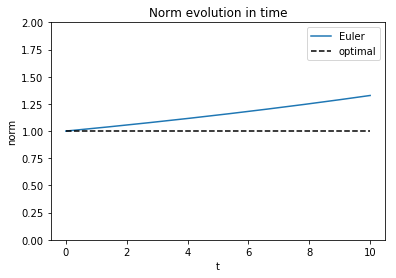

Some observables have non-zero imaginary parts!!


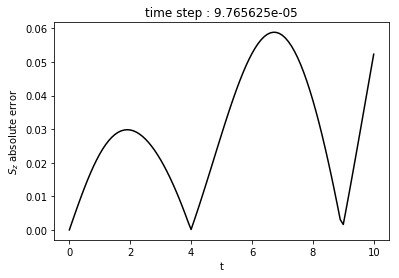

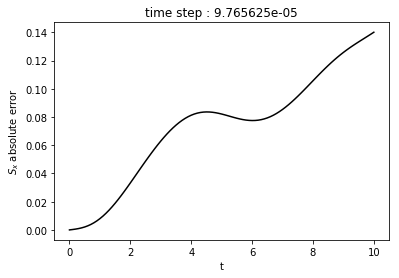

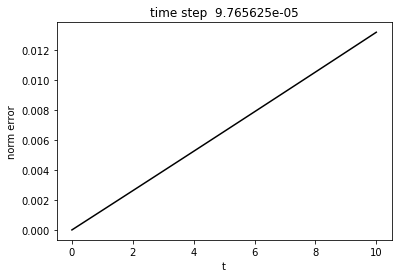

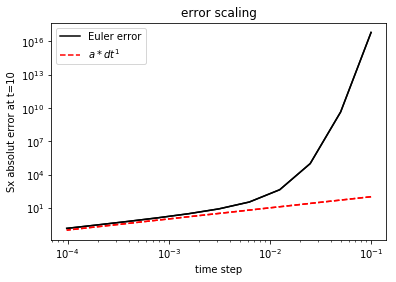

In [39]:
operation(20,0.002,Euler_step)

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

The cell below takes about 20s on my laptop to run.

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

<font color='red'>
Ok but you should add some comments to clarify your conclusions.
    
GRADE: 14/15
</font>

### Exercise 2 (40 points)

Do a corresponding anlysis for a second order Runge Kutta scheme (2nd order Taylor expansion of the evolution operator) and for the two-step method described in https://www5.in.tum.de/lehre/vorlesungen/wipro/ws16/folien/Askar_Explicit_Schroedinger.pdf
[equation (3.2)]. The two-step method matches the Taylor series to second order in dt, so we can use a RK2 step for initialization (to get $\psi_1$ from the initial wave function $\psi_0$).

For this case you can also go beyond $N=20$. Try at least $N=100$. With Euler, really tiny steps would be needed to prevent it from diverging in this case, but higher order integrators should do much better.

time for ED was 0.03397965431213379
time for Runge Kutta 2 was 2.8092703819274902


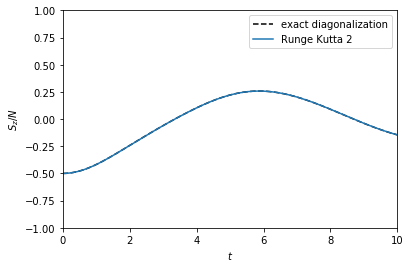

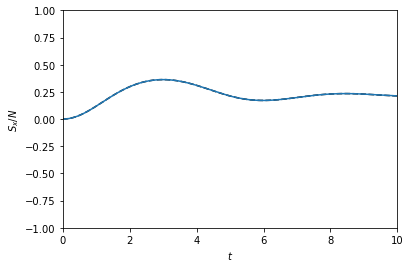

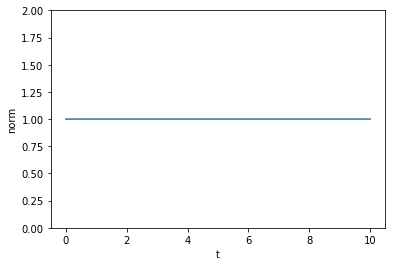

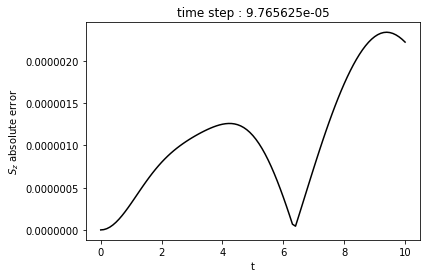

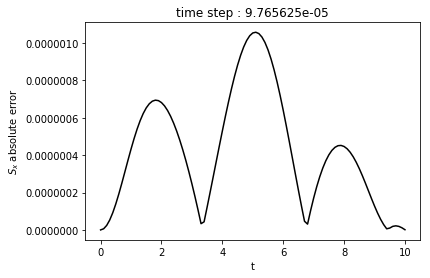

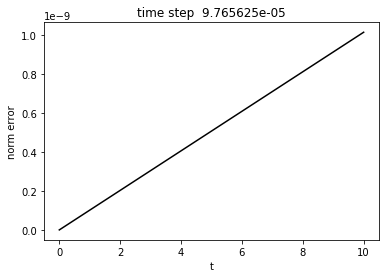

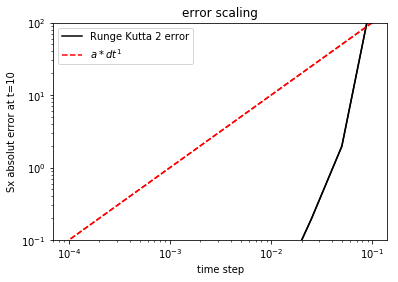

In [25]:
operation(20,0.002,Runge_Kutta2,'Runge Kutta 2')

time for ED was 0.38975954055786133
time for Runge Kutta 2 was 3.475863456726074


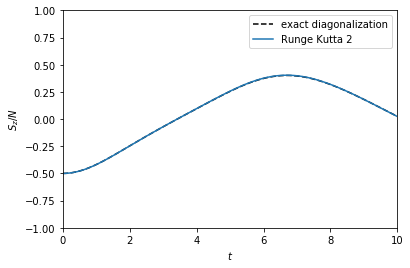

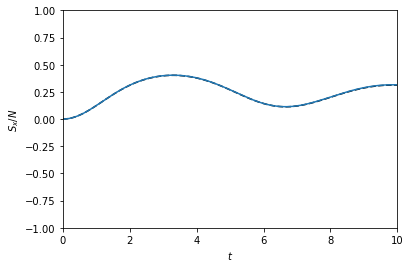

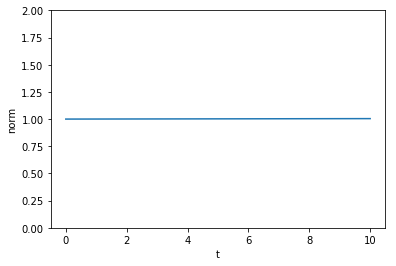

Some observables have non-zero imaginary parts!!


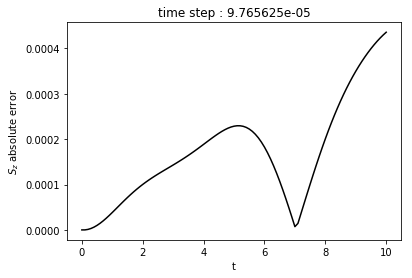

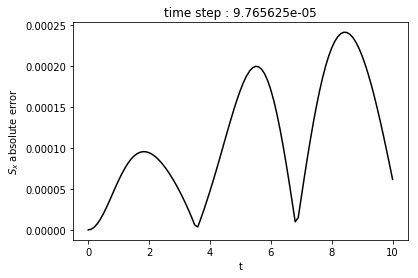

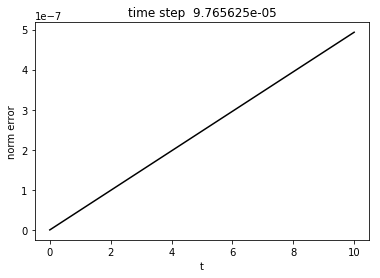

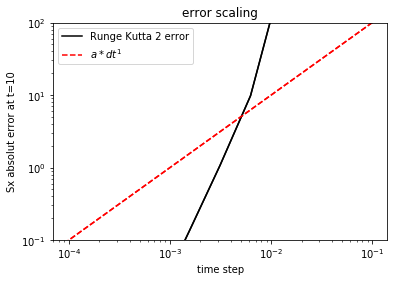

In [26]:
operation(100,0.002,Runge_Kutta2,'Runge Kutta 2')

time for ED was 0.027982234954833984
time for the two step method was 1.5680382251739502


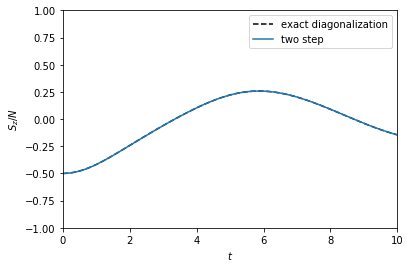

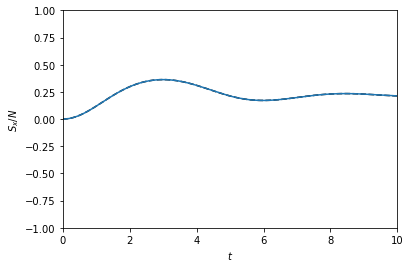

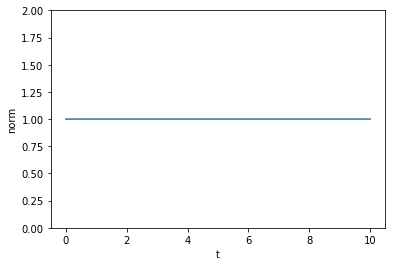

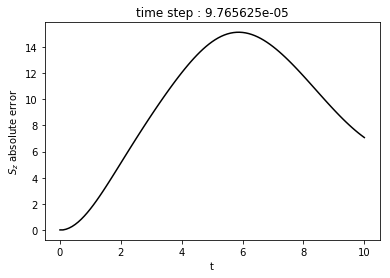

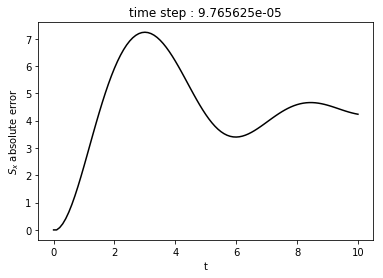

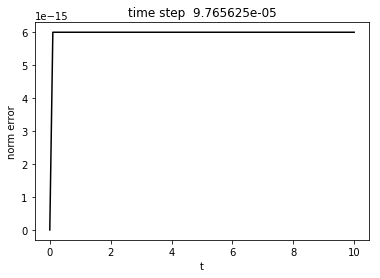

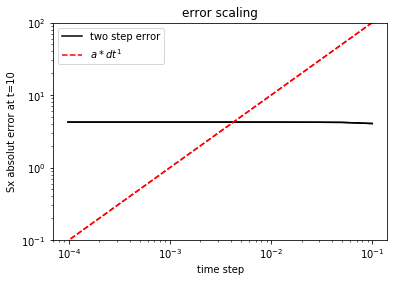

In [27]:
operation(20,0.002,two_step_method,'two step')

<font color='red'>
Good.
    
GRADE: 40/40
</font>

### Exercise 3 (25 points)

Now we want to use a numerical intergrator from the scipy.integrate module. For this I reccomend using the "ode" class which gives the best control of parameters and greatest choice of methods. The documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode

Try different integrators and options. Use a fixed particle number of N=100. Describe your observations. For me, the options that worked best are given as an example below. If you find something faster/mor stable, let me know!

These integrators all use adaptive stepsize internally, so we don't have to analyze the step size dependence of the accuracy. They should in principle always give accurate results or otherwise give a warning message that the specified accuracy goal could not be reached.

In [11]:
# use a scipy out-of-the-box integrator

from scipy.integrate import ode

def f(t, y, Hmat):
    return -1j*Hmat @ y # RHS of the SE


# how efficient is @ for sparse matrices? Is there a more efficient mehtod?
#-as far as I understand scipy.sparse.csr_matrix.dot should be the best option.
# improvement by using the Jacobian?

In [19]:
H=buildH(100,.2)
y=np.array([1]+[0]*100)
%timeit H @ y
%timeit H.dot(y)

The slowest run took 13.18 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 13.3 µs per loop
100000 loops, best of 3: 10.9 µs per loop


time for ED was 0.061959028244018555
time for scipy ode was 1.7119476795196533


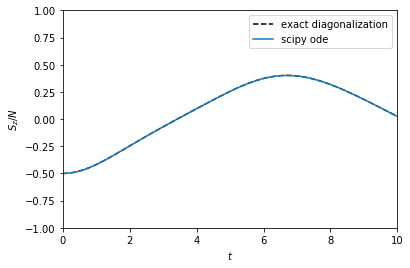

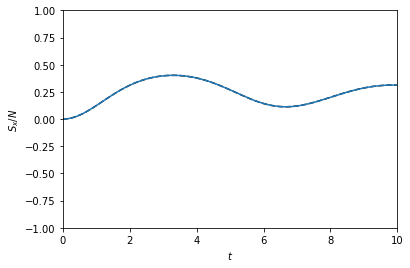

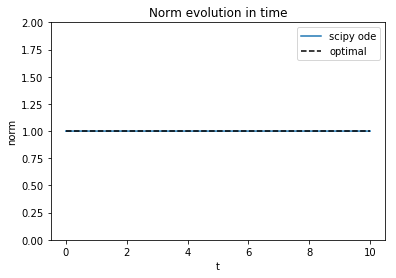

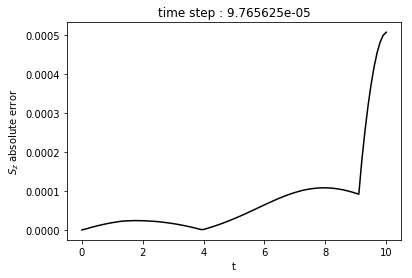

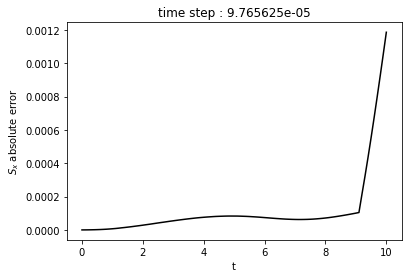

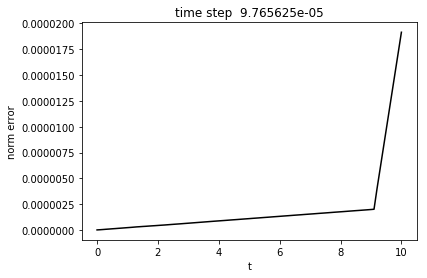

In [46]:
#so maybe dot is a tiny bit faster. but we can't say that for sure with only one time
# initialize the integrator


operation(100,.002,f,'scipy ode',True)


<font color='red'>
Good.
    
GRADE: 25/25
</font>

### Exercise 4 (20 points)

Next, we want to check how their runtime for integrating our ODE scales with the number of spins N (or equivalently the Hilbert space dimension) and compare this to ED. Below is a code where you have to insert only your numerical integrator initialization and stepping.

For me, ED was still faster for up to N=1000. Try to find an integrator that beats by ED implementation!

Describe and interpret your observations.

[Optional] You can also try odeint (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) and/or solve_ivp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). These modules are less object oriented and have a restricted choice of integrators but are somewhat easier to use. 

All the documentation pages have a lot of useful information about the integrators and even links to the original publications in which they were introduced.

[Optional] Implement a Krylov subpace method. A good refernce on the details of this is https://www.sciencedirect.com/science/article/pii/S0010465598000836
The wikipadia page on the Arnoldi iteration even has a python sourrce code for constructing the Krylov vectors.

This method should work much better than the scipy integrators...

In [67]:
# Compare ED to scipy.integrate.ode

dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)

ome = 0.6

# running it to N=2000 takes a few minutes and starts to use significant memeory (for testing, reduce this!)
Nvals = np.arange(200,2001,100) 

observables = 1j*np.zeros((4,len(tvec),len(Nvals))) # for storing the results for Sz and Sx for both methods
runtimes = np.zeros((3,len(Nvals))) # store time for H buildup, ED, and numerical integration

for iN in range(len(Nvals)):
    
    N = Nvals[iN]
    print(N)
    dim = N+1
    ini = np.eye(1,dim,0)[0]

    Sz = buildSz(N)
    Sx = buildSx(N)
    
    t1=time.time()
    Hmat =buildH(N,ome)
    t2=time.time()
    runtimes[0,iN] = t2-t1 # time for H matrix buildup, should be negligible

    # ED solution
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    # calculate time evolution
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i,iN] = Szval
        observables[1,i,iN] = Sxval
    t2=time.time()
    runtimes[1,iN] = t2-t1 # time for ED

    # integrator solution
    t1=time.time()
    t0 = 0
    # set up the integrator
    r = ode(f).set_integrator('zvode', method='adams', with_jacobian=False)
    r.set_initial_value(ini, t0).set_f_params(Hmat)
       
    
    #initial values of observables
    Psit = ini
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[2,0,iN] = Szval
    observables[3,0,iN] = Sxval

    #loop over integrator steps
    for i in range(1,len(tvec)):
        Psit = r.integrate(tvec[i])
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[2,i,iN] = Szval
        observables[3,i,iN] = Sxval

    t2=time.time()
    runtimes[2,iN] = t2-t1 # time for integration
    
    
if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observables = observables.real

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


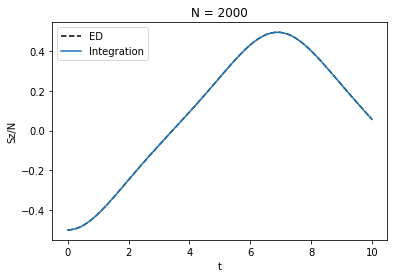

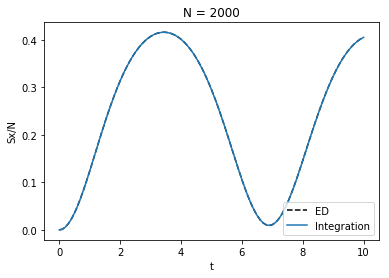

In [68]:
# plotting observables to check that integration was converged and accurate
iN=-1
plt.plot(tvec,observables[0,:,iN]/Nvals[iN],'k--',label='ED')
plt.plot(tvec,observables[2,:,iN]/Nvals[iN],label='Integration')
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sz/N')
plt.legend()
plt.show()

plt.plot(tvec,observables[1,:,iN]/Nvals[iN],'k--',label='ED')
plt.plot(tvec,observables[3,:,iN]/Nvals[iN],label='Integration')
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sx/N')
plt.legend()
plt.show()

In [69]:
from scipy.optimize import curve_fit
def logline(x,a,b):
    return a*x**b

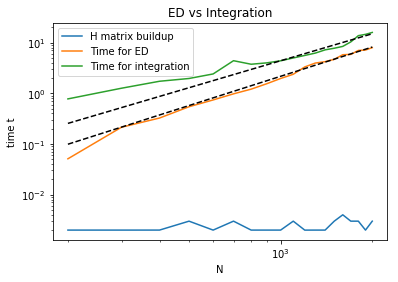

In [70]:
# plotting N-dependence of runtimes
plt.loglog(Nvals,runtimes[0],label='H matrix buildup')
plt.loglog(Nvals,runtimes[1],label='Time for ED')
plt.loglog(Nvals,runtimes[2],label='Time for integration')
ed=curve_fit(logline,Nvals,runtimes[1])[0]
plt.loglog(Nvals,logline(Nvals,*ed),'k--')
i=curve_fit(logline,Nvals,runtimes[2])[0]
plt.loglog(Nvals,logline(Nvals,*i),'k--')
plt.xlabel('N')
plt.ylabel('time t')
plt.title('ED vs Integration')
plt.legend()
plt.show()

On my machine the integration did get close to the ED but never got faster

<font color='red'>
Good. As discussed in the tutorial it seems that some of the overhead from the way we are using the integrators prevents the integration going faster for higher N. Also, you linear fits indicates that the transition will happen for higher N, I think this is due to the specifics of the implementation and/or machine details but I'm not sure.
    
GRADE:  20/20
</font>